In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale pixel values to be between 0 and 1
    rotation_range=40,    # Augment images by rotating up to 40 degrees
    width_shift_range=0.2,  # Augment images by shifting horizontally
    height_shift_range=0.2, # Augment images by shifting vertically
    shear_range=0.2,      # Apply shear transformations
    zoom_range=0.2,       # Apply zoom transformations
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest',  # Fill gaps created by transformations
    validation_split=0.2  # Reserve 20% of data for validation
)

In [13]:
train_generator = train_datagen.flow_from_directory(
    'D:/archive/TB_Chest_Radiography_Database',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'D:/archive/TB_Chest_Radiography_Database',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')


Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [ ]:
model.fit(train_generator, validation_data=validation_generator, epochs=10)


C:\Users\chpiy\anaconda3\envs\tf-env\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


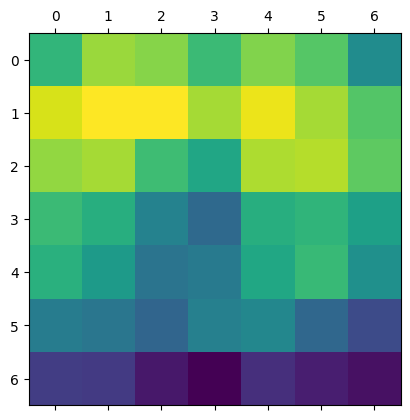

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model


# Ensure image array is converted to a Keras tensor
#img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Access the MobileNetV2 base model
    base_model = model.layers[0]  # Extract MobileNetV2 model from Sequential model


    grad_model = Model(
    inputs=[base_model.input], 
    outputs=[base_model.get_layer(last_conv_layer_name).output, base_model.output]  # Access base model output
)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Binary classification loss

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Apply gradients to feature maps
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Load and preprocess image
img_path = r"D:\archive\TB_Chest_Radiography_Database\Normal\Normal-1.png"
img_array = get_img_array(img_path, size=(224, 224))

# Generate Grad-CAM heatmap
# heatmap = make_gradcam_heatmap(img_array, model, 'Conv_1')    # 'Conv_1' is the last conv layer in MobileNetV2
heatmap = make_gradcam_heatmap(img_array, model, 'Conv_1')  # Use correct layer reference


# Display heatmap
plt.matshow(heatmap)
plt.show()


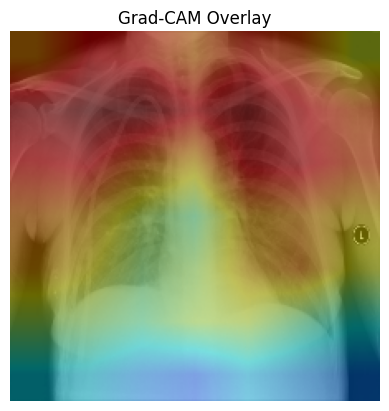

In [17]:
# Load original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

# Rescale heatmap to 0–255
heatmap = np.uint8(255 * heatmap)

# Resize the heatmap to match the image size
heatmap = cv2.resize(heatmap, (224, 224))  # FIX: Resize heatmap correctly

# Apply heatmap to original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Display result
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Grad-CAM Overlay')
plt.show()

In [19]:
 model.save('tb_detection_model.h5')
# model.save('tb_detection_model.keras')


In [21]:
# from tensorflow.keras.models import load_model
# model = load_model('tb_detection_model.h5')
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('tb_detection_model.h5')

# Recompile the model with the same loss function, optimizer, and metrics
model.compile(
    optimizer='adam',  # Use the optimizer you trained with
    loss='binary_crossentropy',  # Use the correct loss function for TB detection
    metrics=['accuracy']
)

print("✅ Model successfully recompiled!")

✅ Model successfully recompiled!


In [23]:
predictions = model.predict(img_array)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
[[0.5475104]]


In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np

# 🖼️ Path to your chest X-ray image
img_path = r"D:\archive\TB_Chest_Radiography_Database\Normal\Normal-1.png"  # Fix the path

# 📦 Preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# 🔮 Make prediction
prediction = model.predict(img_array)[0][0]

# 📢 Show result
if prediction > 0.5:
    print(f"✅ TB Detected! (Confidence: {prediction:.2f})")
else:
    print(f"❎ Normal. (Confidence: {1 - prediction:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
✅ TB Detected! (Confidence: 0.86)
